# Training an object detection AI model using YOLOv5 with OpenShift Data Science (Part 1)

### Setting up the environment and installing suitable dependencies

In [1]:
# We will start by installing the library to download the images
!pip install -q openimages

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sahi 0.11.15 requires opencv-python<=4.8, but you have opencv-python 4.8.1.78 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# We must also make sure we have the right version of opencv
# We must run this. Otherwise, the YOLOv5 function cannot run and output "ImportError: libGL.so.1: cannot open shared object file: No such file or directory"
!pip uninstall -qy opencv-python
!pip install -q opencv-python-headless # Version meant to be used in a containerized environment


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import helper_functions as helper
import numpy as np
import os, random, math

# Part 1: Data preparation and preprocessing

### Download dataset

We will now download the dataset for 3 classes: Bicyle, Car, and Trafic sign. We are only downloading 300 images per class to limit the processing time in this example. However, to achieve a robust YOLOv5 model, it is recommended to train with over 1500 images per class, and more then 10,000 instances per class. We specify the darknet format (–format darknet), which is the format YOLO can handle. This will create folders for each class, in which we will have darknet and images folders.

In [5]:
labels = 'Bicycle Car "Traffic sign"'
limit = 300

!oi_download_dataset --base_dir download --csv_dir download --labels {labels} --format darknet --limit {limit}

2023-11-07  11:02:11 INFO Downloading 300 train images for class 'bicycle'
100%|█████████████████████████████████████████| 300/300 [00:21<00:00, 14.16it/s]
2023-11-07  11:02:32 INFO Creating 300 train annotations (darknet) for class 'bicycle'
100%|███████████████████████████████████████| 300/300 [00:00<00:00, 3238.83it/s]
2023-11-07  11:02:33 INFO Downloading 300 train images for class 'car'
100%|█████████████████████████████████████████| 300/300 [00:19<00:00, 15.02it/s]
2023-11-07  11:02:53 INFO Creating 300 train annotations (darknet) for class 'car'
100%|███████████████████████████████████████| 300/300 [00:00<00:00, 3189.66it/s]
2023-11-07  11:02:54 INFO Downloading 300 train images for class 'traffic sign'
100%|█████████████████████████████████████████| 300/300 [00:19<00:00, 15.04it/s]
2023-11-07  11:03:14 INFO Creating 300 train annotations (darknet) for class 'traffic sign'
100%|███████████████████████████████████████| 300/300 [00:00<00:00, 3052.42it/s]


### Let's have a look at a sample image.

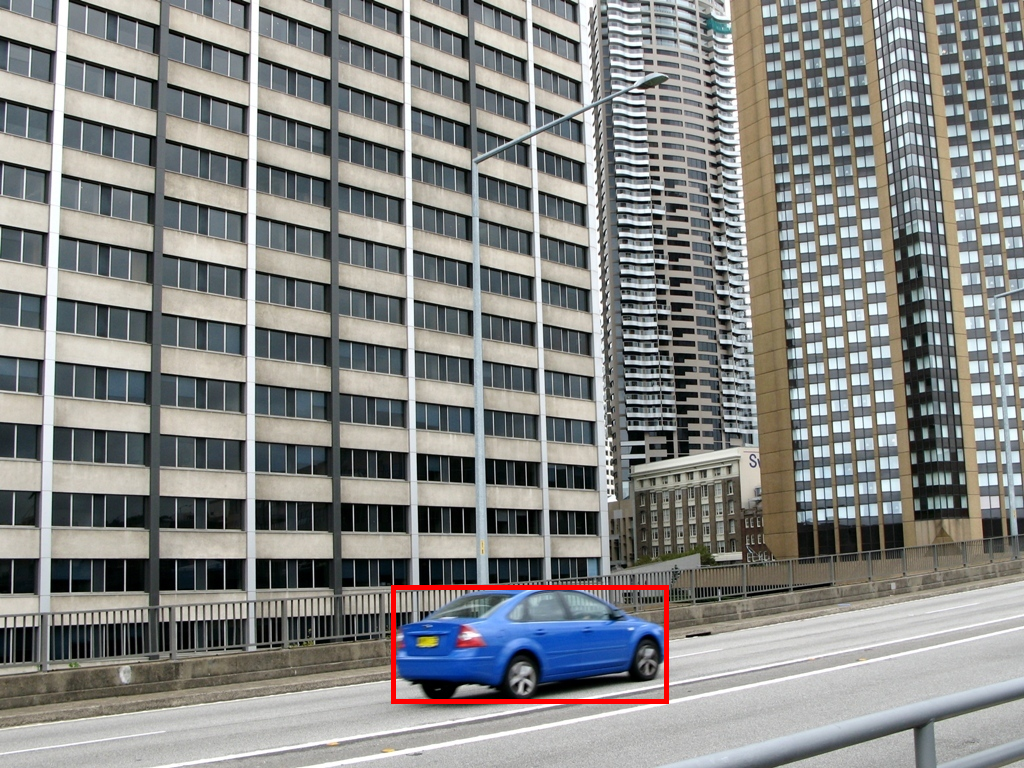

In [6]:
files = os.listdir('download/car/images')
random_file = random.choice(files)

helper.show_bbox('download/car/images/' + random_file)

### Rearrange data into a folder structure for YOLOv5 training

In [7]:
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'data/{folder}/{split}')

### Some images are duplicated across different data catagories, we need to remove duplicates

In [8]:
bicycle_images = helper.get_filenames('download/bicycle/images')
car_images = helper.get_filenames('download/car/images')
traffic_sign_images = helper.get_filenames('download/traffic sign/images')

# Check for duplicates
duplicates1 = bicycle_images & car_images
duplicates2 = car_images & traffic_sign_images
duplicates3 = traffic_sign_images & bicycle_images

# Cleanup duplicates
bicycle_images -= duplicates1
car_images -= duplicates2
traffic_sign_images -= duplicates3

### Randomly split all our images in train/val/test

In [9]:
bicycle_images = np.array(list(bicycle_images))
car_images = np.array(list(car_images))
traffic_sign_images = np.array(list(traffic_sign_images))

# Use the same random seed for reproducability
np.random.seed(42)
np.random.shuffle(bicycle_images)
np.random.shuffle(car_images)
np.random.shuffle(traffic_sign_images)

In [10]:
train_ratio = 0.75
val_ratio = 0.125

In [13]:
# Bicycle data
bicycle_train_size = math.floor(train_ratio * len(bicycle_images))
bicycle_val_size = math.floor(val_ratio * len(bicycle_images))

# Car data
car_train_size = math.floor(train_ratio * len(car_images))
car_val_size = math.floor(val_ratio * len(car_images))

# Traffic sign data
traffic_sign_train_size = math.floor(train_ratio * len(traffic_sign_images))
traffic_sign_val_size = math.floor(val_ratio * len(traffic_sign_images))

In [14]:
helper.split_dataset('bicycle', bicycle_images, train_size=bicycle_train_size, val_size=bicycle_val_size)
helper.split_dataset('car', car_images, train_size=car_train_size, val_size=car_val_size)
helper.split_dataset('traffic sign', traffic_sign_images, train_size=traffic_sign_train_size, val_size=traffic_sign_val_size)